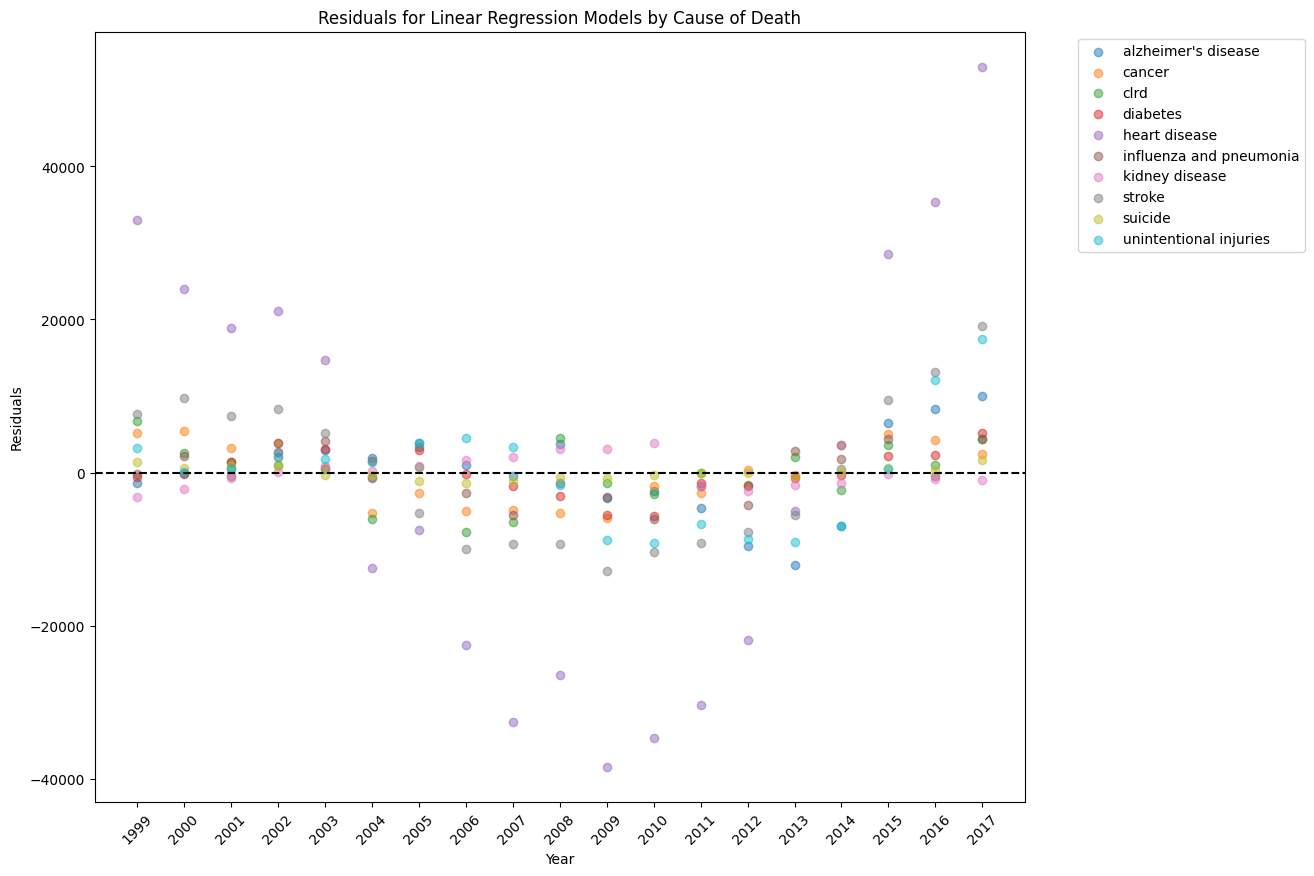

                Cause Name  R² Score
8                  suicide  0.977514
1                   cancer  0.940018
0      alzheimer's disease  0.928098
2                     clrd  0.905756
9   unintentional injuries  0.863716
6           kidney disease  0.801903
5  influenza and pneumonia  0.572891
4            heart disease  0.542460
7                   stroke  0.524857
3                 diabetes  0.508214


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA


df = pd.read_csv('../data/processed/US_Deaths_Populations.csv', sep=',')
df_deaths = df[df["State"] != "United States"]

# Aggregate deaths by year and cause
df_cause_trends = df_deaths.groupby(["Year", "Cause Name"])["Deaths"].sum().unstack()

# Prepare for linear regression analysis
years = df_cause_trends.index.values.reshape(-1, 1)
r2_scores = {}

# Fit linear regression models for each cause of death
plt.figure(figsize=(12, 10))
for cause in df_cause_trends.columns:
    y = df_cause_trends[cause].values
    model = LinearRegression().fit(years, y)
    y_pred = model.predict(years)
    
    # Compute R² score
    r2_scores[cause] = r2_score(y, y_pred)
    
    # Plot residuals
    residuals = y - y_pred
    plt.scatter(years, residuals, label=cause, alpha=0.5)


# Ensure integer year label
plt.xticks(df_cause_trends.index, df_cause_trends.index.astype(int))
plt.xticks(rotation=45)

plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.title("Residuals for Linear Regression Models by Cause of Death")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Display R² scores for each cause of death
r2_scores_df = pd.DataFrame(list(r2_scores.items()), columns=["Cause Name", "R² Score"])
r2_scores_df = r2_scores_df.sort_values(by="R² Score", ascending=False)
print(r2_scores_df)



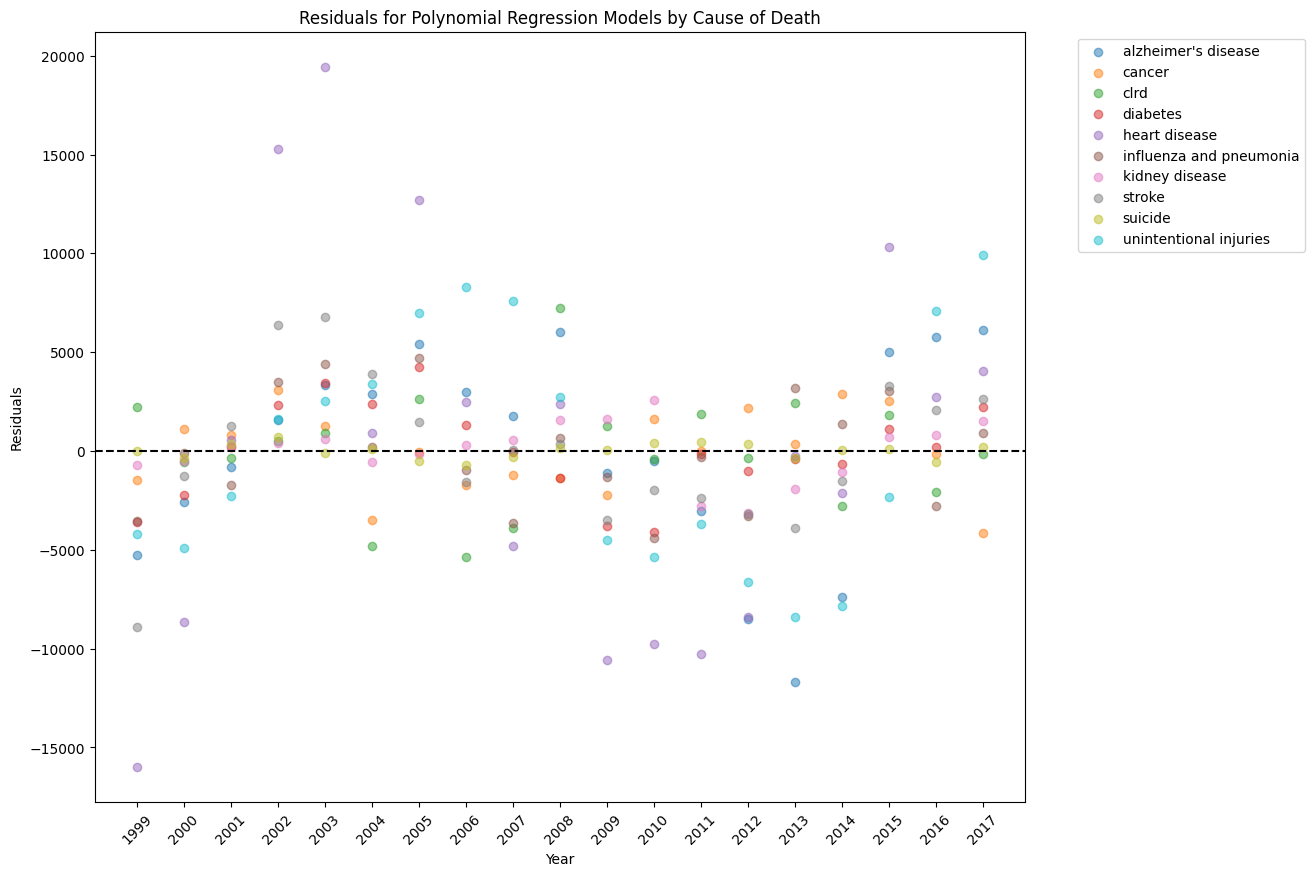

                Cause Name  R² Score  Polynomial R² Score  Improvement
0                  suicide  0.977514             0.995371     0.017857
1                   cancer  0.940018             0.984529     0.044511
2      alzheimer's disease  0.928098             0.937680     0.009581
3                     clrd  0.905756             0.944206     0.038450
4   unintentional injuries  0.863716             0.906236     0.042519
5           kidney disease  0.801903             0.892289     0.090386
6  influenza and pneumonia  0.572891             0.697319     0.124428
7            heart disease  0.542460             0.946533     0.404073
8                   stroke  0.524857             0.926456     0.401599
9                 diabetes  0.508214             0.664190     0.155976
alzheimer's disease        142165.339647
cancer                     632533.378509
clrd                       181374.250895
diabetes                    90728.383167
heart disease              726750.380629
influenza and 

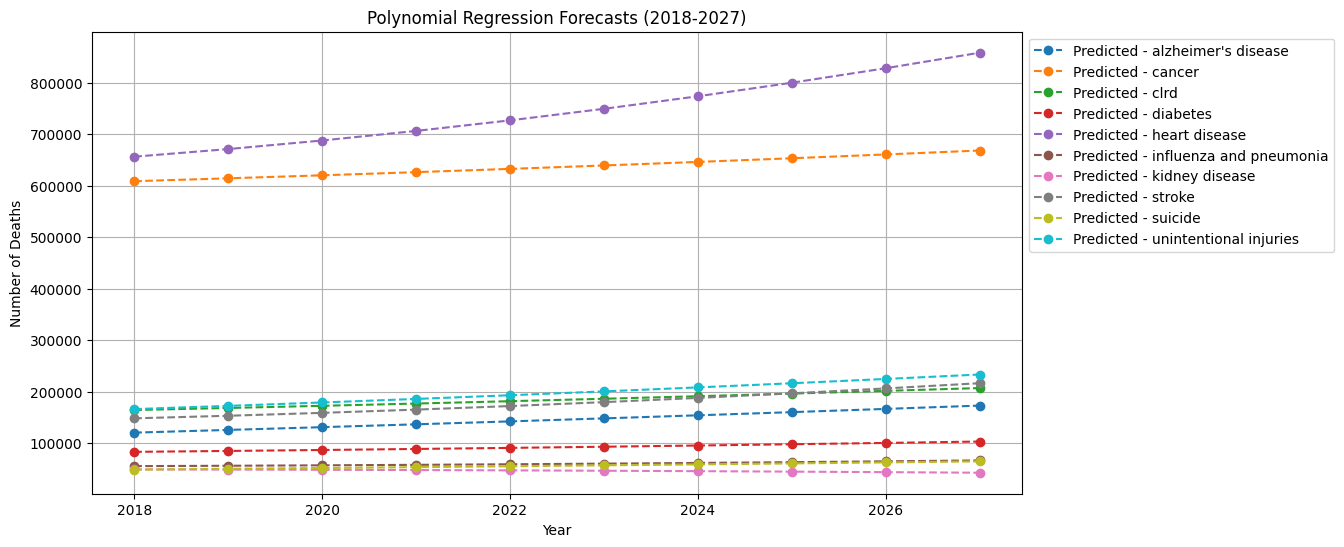

In [11]:
# Define polynomial degree (start with 2nd degree)
degree = 2
r2_scores_poly = {}

# Fit polynomial regression models for each cause of death
plt.figure(figsize=(12, 10))
for cause in df_cause_trends.columns:
    y = df_cause_trends[cause].values
    
    # Create polynomial regression pipeline
    poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model.fit(years, y)
    y_pred = poly_model.predict(years)
    
    # Compute R² score
    r2_scores_poly[cause] = r2_score(y, y_pred)
    
    # Plot residuals
    residuals = y - y_pred
    plt.scatter(years, residuals, label=cause, alpha=0.5)

plt.xticks(df_cause_trends.index, df_cause_trends.index.astype(int))
plt.xticks(rotation=45) 
plt.axhline(y=0, color="black", linestyle="--")
plt.xlabel("Year")
plt.ylabel("Residuals")
plt.title("Residuals for Polynomial Regression Models by Cause of Death")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Display R² scores for polynomial regression
r2_scores_poly_df = pd.DataFrame(list(r2_scores_poly.items()), columns=["Cause Name", "Polynomial R² Score"])
r2_scores_poly_df = r2_scores_poly_df.sort_values(by="Polynomial R² Score", ascending=False)

# Compare with linear regression
r2_comparison = r2_scores_df.merge(r2_scores_poly_df, on="Cause Name")
r2_comparison["Improvement"] = r2_comparison["Polynomial R² Score"] - r2_comparison["R² Score"]

print(r2_comparison)

# Prepare future years (next 10 years)
future_years = np.array(range(2018, 2028)).reshape(-1, 1)

# Dictionary to store predictions
poly_forecasts = {}

# Train and predict using polynomial regression for each disease
for cause in df_cause_trends.columns:
    y = df_cause_trends[cause].values  # Get historical death counts
    
    # Create polynomial regression pipeline
    poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    poly_model.fit(years, y)  # Fit model on historical data
    
    # Predict for next 10 years
    y_future_pred = poly_model.predict(future_years)

    # Store results
    poly_forecasts[cause] = y_future_pred

# Convert results to DataFrame
future_years_flat = future_years.flatten()  # Convert array to flat list
poly_forecasts_df = pd.DataFrame(poly_forecasts, index=future_years_flat)

print(poly_forecasts_df.loc[2022])

plt.figure(figsize=(12, 6))

for cause in df_cause_trends.columns:
    plt.plot(future_years.flatten(), poly_forecasts[cause], label=f"Predicted - {cause}", linestyle="dashed", marker="o")

plt.title("Polynomial Regression Forecasts (2018-2027)")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

21:33:18 - cmdstanpy - INFO - Chain [1] start processing
21:33:18 - cmdstanpy - INFO - Chain [1] done processing
/home/qinyaomou/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
21:33:18 - cmdstanpy - INFO - Chain [1] start processing
21:33:18 - cmdstanpy - INFO - Chain [1] done processing
/home/qinyaomou/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
21:33:18 - cmdstanpy - INFO - Chain [1] start processing
21:33:18 - cmdstanpy - INFO - Chain [1] done processing
/home/qinyaomou/.local/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
21:33:18 - cmdstanpy - INFO - Chain [1] start pro

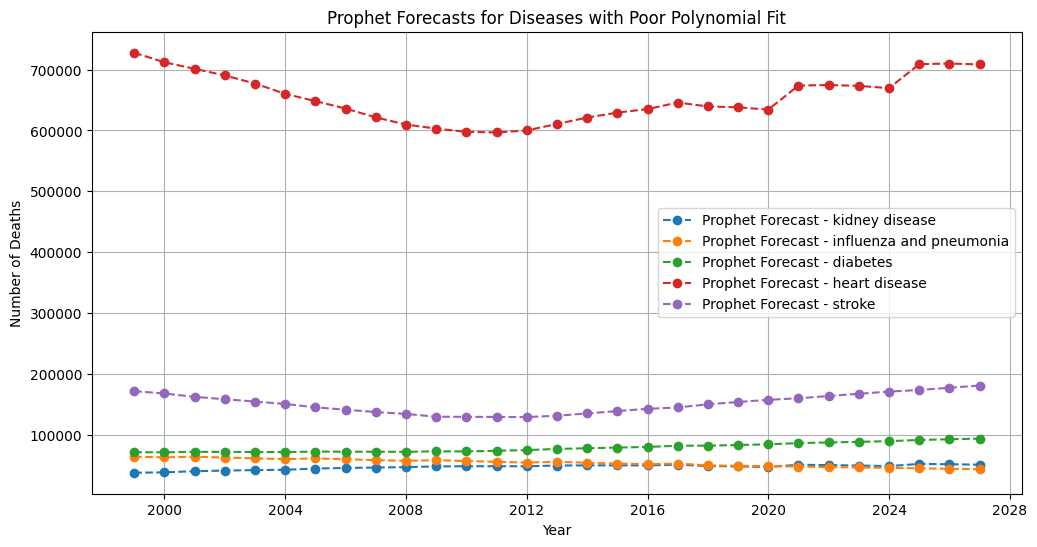

In [12]:
# Define diseases needing Prophet modeling
poor_fit_diseases = ["kidney disease", "influenza and pneumonia", "diabetes", "heart disease", "stroke"]

# Fit Prophet models and generate forecasts
prophet_forecasts = {}
forecast_2022 = {}

for disease in poor_fit_diseases:
    # Prepare data for Prophet
    df_prophet = df_cause_trends[disease].reset_index().rename(columns={"Year": "ds", disease: "y"})
    df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

    # Fit Prophet model
    prophet_model = Prophet()
    prophet_model.fit(df_prophet)

    # Create future dates
    future = prophet_model.make_future_dataframe(periods=10, freq="Y")
    future["ds"] = pd.to_datetime(future["ds"], format="%Y")

    # Generate forecast
    forecast = prophet_model.predict(future)

    # Store forecast results
    prophet_forecasts[disease] = forecast[["ds", "yhat"]].set_index("ds").loc[future["ds"]]
    
# Plot Prophet forecasts
plt.figure(figsize=(12, 6))
for disease, forecast in prophet_forecasts.items():
    plt.plot(forecast.index, forecast, label=f"Prophet Forecast - {disease}", linestyle="dashed", marker="o")

plt.title("Prophet Forecasts for Diseases with Poor Polynomial Fit")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
evaluation_results = {}

for disease in prophet_forecasts.keys():
    # Split data: Train on all but last 5 years
    df_prophet = df_cause_trends[disease].reset_index().rename(columns={"Year": "ds", disease: "y"})
    df_prophet["ds"] = pd.to_datetime(df_prophet["ds"], format="%Y")

    train = df_prophet.iloc[:-5]  # Train on all but last 5 years
    test = df_prophet.iloc[-5:]  # Hold out last 5 years for validation

    # Fit Prophet
    prophet_model = Prophet()
    prophet_model.fit(train)

    # Predict last 5 years
    future = test[["ds"]]
    forecast = prophet_model.predict(future)
    
    # Use ChatGPT to calculate those measurements
    merged = test.merge(forecast[["ds", "yhat"]], on="ds", how="inner")
    
    mae = mean_absolute_error(merged["y"], merged["yhat"])
    mse = mean_squared_error(merged["y"], merged["yhat"])
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((merged["y"] - merged["yhat"]) / merged["y"])) * 100

    # Store results
    evaluation_results[disease] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE (%)": mape}

evaluation_df = pd.DataFrame.from_dict(evaluation_results, orient="index")

print(evaluation_df)


21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] done processing
21:33:19 - cmdstanpy - INFO - Chain [1] start processing
21:33:19 - cmdstanpy - INFO - Chain [1] done processing


                                  MAE           MSE          RMSE   MAPE (%)
kidney disease            3726.976462  1.505882e+07   3880.569401   7.607781
influenza and pneumonia   8416.418680  7.473405e+07   8644.885520  15.156191
diabetes                  6399.578562  4.833868e+07   6952.602049   7.984289
heart disease            40817.180117  1.967216e+09  44353.306913   6.438391
stroke                   13629.110763  2.414168e+08  15537.593130   9.636990


In [14]:
# Apply first-order differencing and re-run the Dickey-Fuller test
adf_results_diff = {}

for disease in ["kidney disease", "influenza and pneumonia", "diabetes", "heart disease", "stroke"]:
    ts_data_diff = df_cause_trends[disease].dropna().diff().dropna()
    
    # Perform Augmented Dickey-Fuller test
    adf_test_diff = adfuller(ts_data_diff)
    adf_results_diff[disease] = {
        "ADF Statistic": adf_test_diff[0],
        "p-value": adf_test_diff[1],
        "Critical Values": adf_test_diff[4],
         # If p-value < 0.05, data is now stationary
        "Stationary?": adf_test_diff[1] < 0.05
    }

# Display stationarity test results after first differencing
adf_results_diff_df = pd.DataFrame.from_dict(adf_results_diff, orient="index")
print("Dickey-Fuller Test After First Differencing", adf_results_diff_df)


Dickey-Fuller Test After First Differencing                          ADF Statistic       p-value  \
kidney disease                1.598956  9.978544e-01   
influenza and pneumonia      -7.133940  3.460005e-10   
diabetes                     -1.476567  5.450697e-01   
heart disease                -0.920406  7.811783e-01   
stroke                        1.351756  9.968836e-01   

                                                           Critical Values  \
kidney disease           {'1%': -4.223238279489106, '5%': -3.1893689256...   
influenza and pneumonia  {'1%': -3.889265672705068, '5%': -3.0543579727...   
diabetes                 {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}   
heart disease            {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}   
stroke                   {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}   

                         Stationary?  
kidney disease                 False  
influenza and pneumonia         True  
diabetes                       Fa

In [15]:
adf_results_diff2 = {}

# Only these need further differencing
for disease in ["kidney disease", "diabetes", "heart disease", "stroke"]: 
    ts_data_diff2 = df_cause_trends[disease].dropna().diff().diff().dropna()
    
    # Perform Augmented Dickey-Fuller test
    adf_test_diff2 = adfuller(ts_data_diff2)
    adf_results_diff2[disease] = {
        "ADF Statistic": adf_test_diff2[0],
        "p-value": adf_test_diff2[1],
        "Critical Values": adf_test_diff2[4],
        "Stationary?": adf_test_diff2[1] < 0.05
    }

# Display stationarity test results after second differencing
adf_results_diff2_df = pd.DataFrame.from_dict(adf_results_diff2, orient="index")
print("Dickey-Fuller Test After Second Differencing", adf_results_diff2_df)

Dickey-Fuller Test After Second Differencing                 ADF Statistic       p-value  \
kidney disease      -6.718668  3.528497e-09   
diabetes            -7.223985  2.076012e-10   
heart disease       -6.268215  4.064490e-08   
stroke              -2.633260  8.631599e-02   

                                                  Critical Values  Stationary?  
kidney disease  {'1%': -4.223238279489106, '5%': -3.1893689256...         True  
diabetes        {'1%': -3.9240193847656246, '5%': -3.068498203...         True  
heart disease   {'1%': -3.9644434814814815, '5%': -3.084908148...         True  
stroke          {'1%': -4.068853732362312, '5%': -3.1271488757...        False  


In [16]:
# Apply third-order differencing and re-run the Dickey-Fuller test for Stroke
ts_data_diff3 = df_cause_trends["stroke"].dropna().diff().diff().diff().dropna()

# Perform Augmented Dickey-Fuller test
adf_test_diff3 = adfuller(ts_data_diff3)
adf_results_diff3_stroke = {
    "ADF Statistic": adf_test_diff3[0],
    "p-value": adf_test_diff3[1],
    "Critical Values": adf_test_diff3[4],
    "Stationary?": adf_test_diff3[1] < 0.05
}

# Display stationarity test results after third differencing for Stroke
adf_results_diff3_stroke_df = pd.DataFrame.from_dict(adf_results_diff3_stroke, orient="index", columns=["Value"])
print("Dickey-Fuller Test After Third Differencing (Stroke)", adf_results_diff3_stroke_df)


Dickey-Fuller Test After Third Differencing (Stroke)                                                              Value
ADF Statistic                                             -5.22121
p-value                                                   0.000008
Critical Values  {'1%': -4.473135048010974, '5%': -3.2898806035...
Stationary?                                                   True


/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported i

Best ARIMA Parameters for Each Disease:
kidney disease: (0, 2, 0)
diabetes: (0, 2, 0)
heart disease: (0, 2, 0)
influenza and pneumonia: (0, 2, 0)
stroke: (0, 3, 1)
Disease: kidney disease
Forecasted Values:
19    51220.0
20    51807.0
21    52394.0
22    52981.0
23    53568.0
24    54155.0
25    54742.0
26    55329.0
27    55916.0
28    56503.0
Name: predicted_mean, dtype: float64

Disease: diabetes
Forecasted Values:
19     87070.0
20     90576.0
21     94082.0
22     97588.0
23    101094.0
24    104600.0
25    108106.0
26    111612.0
27    115118.0
28    118624.0
Name: predicted_mean, dtype: float64

Disease: heart disease
Forecasted Values:
19    659654.0
20    671851.0
21    684048.0
22    696245.0
23    708442.0
24    720639.0
25    732836.0
26    745033.0
27    757230.0
28    769427.0
Name: predicted_mean, dtype: float64

Disease: influenza and pneumonia
Forecasted Values:
19    59807.0
20    63942.0
21    68077.0
22    72212.0
23    76347.0
24    80482.0
25    84617.0
26    8875

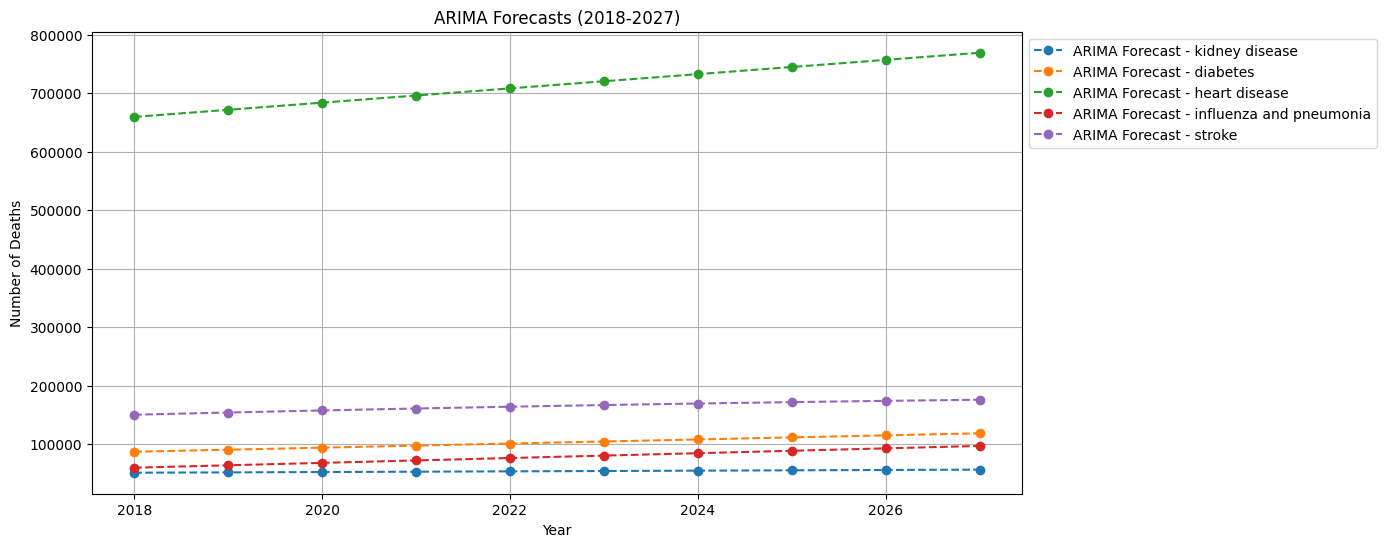

In [17]:
# Define diseases and their corresponding differencing orders
differencing_orders = {
    "kidney disease": 2, 
    "diabetes": 2,       
    "heart disease": 2,  
    "influenza and pneumonia": 2,
    "stroke": 3
}

# Use ChatGPT's help to run ARIMA analysis
# Define ARIMA parameter ranges
p = range(0, 3)
q = range(0, 3)

# Dictionary to store best ARIMA parameters for each disease
best_arima_params = {}

# Find the Best ARIMA Parameters for Each Disease
for disease, d in differencing_orders.items():
    ts_data = df_cause_trends[disease].dropna()
    
    best_aic = float("inf")
    best_pdq = None

    for pdq in itertools.product(p, [d], q):
        try:
            model = ARIMA(ts_data, order=pdq).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_pdq = pdq
        except:
            continue

    best_arima_params[disease] = {"Best (p,d,q)": best_pdq, "AIC": best_aic}

# Print best ARIMA parameters for each disease
print("Best ARIMA Parameters for Each Disease:")
for disease, params in best_arima_params.items():
    print(f"{disease}: {params['Best (p,d,q)']}")

forecast_periods = 10
arima_forecasts = {}

for disease, params in best_arima_params.items():
    ts_data = df_cause_trends[disease].dropna()
    p, d, q = params["Best (p,d,q)"]

    try:
        model = ARIMA(ts_data, order=(p, d, q)).fit()
        arima_forecast = model.forecast(steps=forecast_periods)

        print(f"Disease: {disease}")
        print(f"Forecasted Values:\n{arima_forecast}\n")

        future_years = np.arange(2018, 2028)
        arima_forecasts[disease] = pd.Series(data=arima_forecast.values, index=future_years)
    
    except Exception as e:
        print(f"Error forecasting for {disease}: {e}")

# Convert forecasts to DataFrame
arima_forecasts_df = pd.DataFrame(arima_forecasts) 

# Plot ARIMA Forecasts
plt.figure(figsize=(12, 6))
for disease in arima_forecasts_df.columns:
    plt.plot(arima_forecasts_df.index, arima_forecasts_df[disease], label=f"ARIMA Forecast - {disease}", linestyle="dashed", marker="o")

plt.title("ARIMA Forecasts (2018-2027)")
plt.xlabel("Year")
plt.ylabel("Number of Deaths")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()


In [18]:
# Calculate MSPE (Mean Squared Percentage Error)
arima_evaluation = {}

for disease in best_arima_params.keys():
    ts_data = df_cause_trends[disease].dropna()

    # Define train-test split (last 5 years for testing)
    test_years = 5
    train = ts_data.iloc[:-test_years]
    test = ts_data.iloc[-test_years:].reset_index()

    p, d, q = best_arima_params[disease]["Best (p,d,q)"]

    # Fit ARIMA
    model = ARIMA(train, order=(p, d, q)).fit()

    # Generate forecast for test period
    future_years = test["Year"]
    forecast = pd.DataFrame({"Year": future_years, "yhat": model.forecast(steps=test_years).values})

    # Merge actual test values with forecasted values
    merged = test.merge(forecast, on="Year", how="inner")

    # Drop NaNs before error calculation
    merged.dropna(subset=[disease, "yhat"], inplace=True)

    # Compute error metrics if data is valid
    if not merged.empty:
        mae = mean_absolute_error(merged[disease], merged["yhat"])
        mse = mean_squared_error(merged[disease], merged["yhat"])
        rmse = np.sqrt(mse)

        # Use ChatGPT's help to calculate MSPE: Avoid division by zero
        epsilon = 1e-9  # Small constant to prevent division errors
        merged[disease] = merged[disease].replace(0, epsilon)

        if merged[disease].notna().sum() > 0:
            mspe = np.mean(((merged[disease] - merged["yhat"]) / merged[disease])**2) * 100
        else:
            mspe = np.nan
    else:
        print(f"No valid data for {disease} after dropping NaNs")
        mae, mse, rmse, mspe = np.nan, np.nan, np.nan, np.nan

    # Store results
    arima_evaluation[disease] = {"MAE": mae, "MSE": mse, "RMSE": rmse, "MSPE (%)": mspe}

# Convert evaluation results to DataFrame
arima_evaluation_df = pd.DataFrame.from_dict(arima_evaluation, orient="index")
print(arima_evaluation_df)

                                  MAE           MSE          RMSE  MSPE (%)
kidney disease            3464.200000  1.365448e+07   3695.196801  0.547415
diabetes                  4809.600000  3.041235e+07   5514.739414  0.456868
heart disease            19289.400000  4.616518e+08  21486.084553  0.113142
influenza and pneumonia  14229.400000  2.188296e+08  14792.890610  7.167959
stroke                   14907.561553  3.162039e+08  17782.123884  1.533281


/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/qinyaomou/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported ind